# Autoencoder example with Keras

An example autoencoder neural net (NN) built using the keras API.
This is a python package that gives access to Google's TensorFlow
back end. Installation instructions can be found in the README.md
file.

This example is taken from https://blog.keras.io/building-autoencoders-in-keras.html
with updates to python3 and some added (hopefully useful) examples
of the keras API.

What we are going to try to do is create an autoencoder that takes
a noisy image of a number, and removes the noise. We'll train the 
autoencoder on noise-free images.

## Setup the backend

Keras can run with either TensorFlow or Theano back end (see https://keras.io/backend/).
TensorFlow is the default, the easy way to to change to Theano
is to set an environment variable. For a Jupyter notebook running under
bash do `export KERAS_BACKEND=theano` before launching the server.

The TensorFlow backend seems to grab all the avalable cores for its
computation. This is not idea on a shared machine (or on my laptop, 
which only has two cores, but ends up with four threads due to
hyperthreading slowing everything else down). We can tweak the 
settings for this before we do anything else.

In [1]:
# Limit the number of threads - useful on a shared machine.
# From https://github.com/fchollet/keras/issues/4740 and
# https://www.tensorflow.org/api_docs/python/tf/ConfigProto

num_cores = 4

from keras import backend as K

if K.backend() == 'tensorflow':
    import tensorflow as tf
    print("Setting tensorflow to use {} cores".format(num_cores))
    config = tf.ConfigProto(intra_op_parallelism_threads=num_cores, 
                            inter_op_parallelism_threads=num_cores,
                            allow_soft_placement=True,
                            device_count = {'CPU': num_cores})
    session = tf.Session(config=config)
    K.set_session(session)

Using TensorFlow backend.


Setting tensorflow to use 4 cores


## Get some data and make it noisy

Usefully, keras comes with some standard data sets (which are
often found as examples in textbooks). We use a set of hand
written didgets taken from envelopes in the US and cleaned up.
We will add noise to these. The NN will (hopefully) remove the 
noise once we have trained it on noise free examples.

In [2]:
from keras.datasets import mnist
import numpy as np

# Read example data
(x_train, _), (x_test, _) = mnist.load_data()

# Turn integer data into 32 bit floats.
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1)) 
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1)) 

# Generate noisy data
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

# Limit maximum and minimum of noisy data
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)


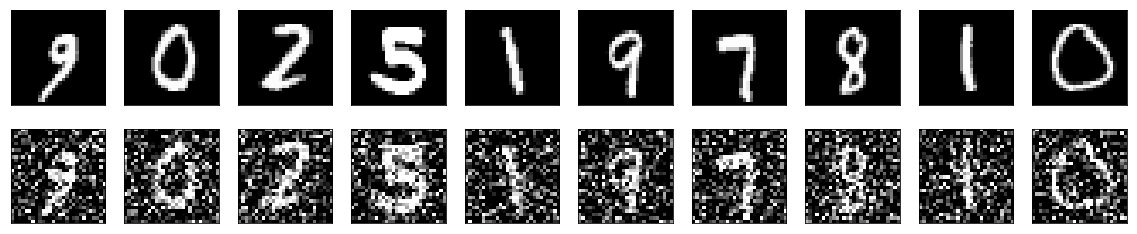

In [3]:
# Look at 10 noisy and noise-free pictures

import matplotlib.pyplot as plt

n = 10
start = 1000 # first number to show
plt.figure(figsize=(20, 4))
for i in range(n):
    
    # No noise
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i+start].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # With noise
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_test_noisy[i+start].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Define and fit the NN

We'll take the autoencoder design directly from the example in the Keras
blog post. It's a non-trival design that seems to work. I'm not clear 
about how this was chosen (or how to choose it).

In [4]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(28, 28, 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32) - this is the "bottle neck"

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [5]:
%%time

# This is the expensive bit, choosing all the weights
# I set verbose=0 as the reporting callback does not
# play well with Jupyter (web browser crashes).

autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                verbose=0)

CPU times: user 12h 2min 8s, sys: 3h 17min 26s, total: 15h 19min 35s
Wall time: 17h 38min 57s


## Save the model

That took quite a lot longer than I expected. Before I do anything 
else I'll store the fitted model to disk, so I can recreate it
without re-fitting.

It looks like the best way to store a Keras `Model` is as two files.
The first, in JSON format, represents the structure of the NN. The second,
an HDF5 binary file, stores all the weights and other model parameters.
It seems sensible to have a function to store both together.

I'll also write something to read in the model then work with that.

In [6]:
def save_keras_model(model, model_name):
    """Function to save a Keras model
    
    Saves a NN to a .json file (for the structure) and 
    .h5 file (for the weights)."""
    # Save the NN structure
    with open(model_name + ".json", "w") as json_file:
        json_file.write(model.to_json())
        
    # Save the NN weights
    model.save_weights(model_name + ".h5")

In [7]:
save_keras_model(autoencoder, "denoising_autoencoder")

In [11]:
from keras.models import model_from_json

def load_keras_model(model_name):
    """Function to read a Keras model
    
    Reads a NN from a .json file (for the structure) and
    .h5 file (for the weights) and returns a model."""
    # Load the model structure
    with open(model_name + ".json", "r") as json_file:
        json_string = json_file.read()
    model = model_from_json(json_string)

    # load weights into new model
    model.load_weights(model_name + ".h5")
    
    return model    

In [12]:
denoise = load_keras_model("denoising_autoencoder")

## Look at the model

Inspect the model to see what it is made of.

In [13]:
denoise.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 32)          9248      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 32)        0         
__________

## Use the model

How well does it work? We'll look with some test data (not used for
fitting).

Then we'll just plot the input, the noisy input and the denoised output.


In [29]:
# Try to remove noise from all test data.
x_denoised = denoise.predict(x_test_noisy)


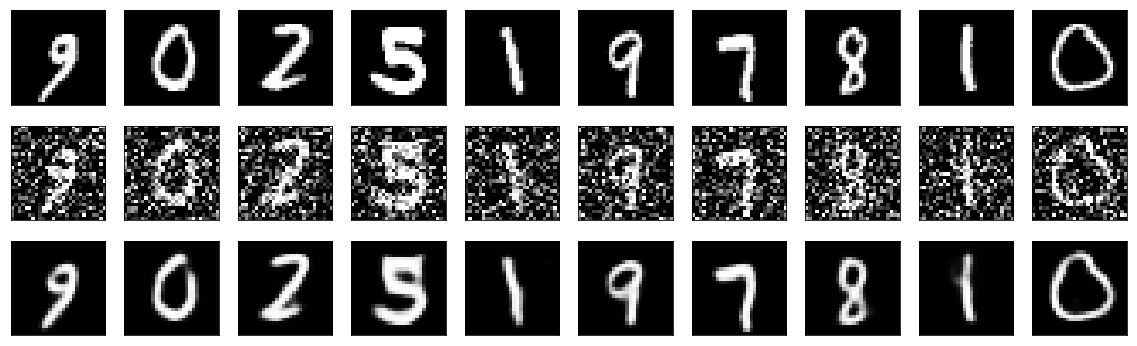

In [30]:
# Look at 10 noisy and noise-free pictures

import matplotlib.pyplot as plt

n = 10
start = 1000 # first number to show

plt.figure(figsize=(20, 6))
for i in range(n):
    
    # No noise
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i+start].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # With noise
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i+start].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # With noise removed
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(x_denoised[i+start].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()